In [1]:
import pandas as pd 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np 
import matplotlib.pyplot as plt 
import itertools
import seaborn as sns 
sns.set(style="darkgrid")
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sub = pd.read_csv('../input/sample_submission.csv')

In [3]:
print(train.dropna().shape)
print(train.shape)
print(f'nvalues lost: {train.shape[0]-train.dropna().shape[0]}')

(298042, 25)
(600000, 25)
nvalues lost: 301958


- half the values are lost if we just drop the null values, imputation will be needed

In [4]:
test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,F,Y,Blue,Polygon,Axolotl,Finland,Piano,52f6dd16c,147d704e4,8d857a0a1,ca9ad1d4b,fced9e114,3.0,Novice,Boiling Hot,f,U,oU,3.0,9.0
1,600001,0.0,0.0,0.0,F,Y,Red,Circle,Lion,Russia,Bassoon,691ebeae8,8653dcc2e,67a8d4ebb,060a21580,7ca8775da,1.0,Novice,Cold,n,N,NaN,2.0,8.0
2,600002,0.0,0.0,0.0,F,Y,Blue,Circle,Axolotl,Russia,Theremin,81f792c16,6cdda499e,69403e18c,165e81a00,5940334c9,1.0,Expert,Warm,i,N,DN,2.0,6.0
3,600003,1.0,0.0,0.0,F,N,Red,Polygon,Axolotl,Costa Rica,Bassoon,c9134205b,acbca4827,cb681246b,77d41330d,6fbdeefc8,1.0,Expert,Hot,m,B,AG,1.0,6.0
4,600004,0.0,0.0,1.0,F,Y,Red,Circle,NaN,Finland,Theremin,f0f100f57,6f800b9af,cd9feb5c6,2218d9dfe,2a27c8fde,1.0,Contributor,Lava Hot,o,J,DT,3.0,3.0


In [44]:
sub.head()

,id,target
0,600000,0.5
1,600001,0.5
2,600002,0.5
3,600003,0.5
4,600004,0.5


In [5]:
#test set also have missing values
for col in test.columns:
    print(f'{col} null values: {test[col].isnull().sum()}/{test.shape[0]} - \
prop: {round(test[col].isnull().sum()/test.shape[0], 3)}')

id null values: 0/400000 - prop: 0.0
bin_0 null values: 11901/400000 - prop: 0.03
bin_1 null values: 12038/400000 - prop: 0.03
bin_2 null values: 11972/400000 - prop: 0.03
bin_3 null values: 11951/400000 - prop: 0.03
bin_4 null values: 11951/400000 - prop: 0.03
nom_0 null values: 12062/400000 - prop: 0.03
nom_1 null values: 11947/400000 - prop: 0.03
nom_2 null values: 12179/400000 - prop: 0.03
nom_3 null values: 12176/400000 - prop: 0.03
nom_4 null values: 11993/400000 - prop: 0.03
nom_5 null values: 11912/400000 - prop: 0.03
nom_6 null values: 12012/400000 - prop: 0.03
nom_7 null values: 12003/400000 - prop: 0.03
nom_8 null values: 11956/400000 - prop: 0.03
nom_9 null values: 12060/400000 - prop: 0.03
ord_0 null values: 11893/400000 - prop: 0.03
ord_1 null values: 12167/400000 - prop: 0.03
ord_2 null values: 12105/400000 - prop: 0.03
ord_3 null values: 12053/400000 - prop: 0.03
ord_4 null values: 11933/400000 - prop: 0.03
ord_5 null values: 12047/400000 - prop: 0.03
day null values: 1

- the test set has missing values as well test set will have to be imputed as well

In [6]:
# check head and dimensions
print(train.shape)
train.head()

(600000, 25)


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [7]:
train.columns

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'target'],
      dtype='object')

# Convert features from object to float

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 25 columns):
id        600000 non-null int64
bin_0     582106 non-null float64
bin_1     581997 non-null float64
bin_2     582070 non-null float64
bin_3     581986 non-null object
bin_4     581953 non-null object
nom_0     581748 non-null object
nom_1     581844 non-null object
nom_2     581965 non-null object
nom_3     581879 non-null object
nom_4     581965 non-null object
nom_5     582222 non-null object
nom_6     581869 non-null object
nom_7     581997 non-null object
nom_8     582245 non-null object
nom_9     581927 non-null object
ord_0     581712 non-null float64
ord_1     581959 non-null object
ord_2     581925 non-null object
ord_3     582084 non-null object
ord_4     582070 non-null object
ord_5     582287 non-null object
day       582048 non-null float64
month     582012 non-null float64
target    600000 non-null int64
dtypes: float64(6), int64(2), object(17)
memory usage: 114.4

In [9]:
from tqdm import tqdm_notebook as tqdm
def label_encode(data, feats):
    df = data.copy(deep = True)
    dict_of_dicts = {}
    with tqdm(total=len(feats)) as pbar: 
        for col in feats:
            pbar.update(1)
            length = []
            values = []
            encoder_dict = {}
            for idx, val in zip(range(len(df[col].unique())),df[col].unique()):
                if str(val) == 'nan':
                    pass
                else:
                    length.append(idx)
                    values.append(val)
            for l,v in zip(length, values):
                encoder_dict[v] = l

            dict_of_dicts[col] = encoder_dict

            df[col] = df[col].replace(dict_of_dicts.get(col))
        
    return df

# Binary features

In [10]:
binary = []
for col in train.columns:
    if 'bin' in col:
        binary.append(col)
print(binary)
    

#check distributions

['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']


In [11]:
def binary_processor(data):
    df = data.copy(deep = True)
    # get binary columns
    binary = []
    for col in df.columns:
        if 'bin' in col:
            binary.append(col)
            
    #label encoder for binary feats
    print('progress bar for label encoder: \n')
    df = label_encode(df, feats = ['bin_3', 'bin_4'])
    
    # bin_0
    df['bin_0'] = df['bin_0'].replace(np.nan, df['bin_0'].value_counts().index[0])
    # bin_1
    df['bin_1'] = df['bin_1'].replace(np.nan, df['bin_1'].value_counts().index[0])
    # bin_2
    df['bin_2'] = df['bin_2'].replace(np.nan, df['bin_2'].value_counts().index[0])
    # bin_3
    df['bin_3'] = df['bin_3'].replace(np.nan, df['bin_3'].value_counts().index[0])
    # bin_4
    df['bin_4'] = df['bin_4'].replace(np.nan, df['bin_4'].value_counts().index[0])
    
    
    # sanity check
    #sanity_check
    print('missing values for binary cols')
    for col in binary:
        print(f'{col} null values: {df[col].isnull().sum()}/{df.shape[0]} - \
    prop: {round(df[col].isnull().sum()/df.shape[0], 3)}')
    
    return df

In [12]:
train = binary_processor(train)
train.head()

progress bar for label encoder: 




missing values for binary cols
bin_0 null values: 0/600000 -     prop: 0.0
bin_1 null values: 0/600000 -     prop: 0.0
bin_2 null values: 0/600000 -     prop: 0.0
bin_3 null values: 0/600000 -     prop: 0.0
bin_4 null values: 0/600000 -     prop: 0.0


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,0.0,0.0,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,0.0,1.0,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,0.0,0.0,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,0.0,0.0,0.0,0.0,0.0,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,0.0,0.0,1.0,0.0,Red,Triangle,Hamster,Costa Rica,NaN,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [13]:
test = binary_processor(test)
test.head()

progress bar for label encoder: 




missing values for binary cols
bin_0 null values: 0/400000 -     prop: 0.0
bin_1 null values: 0/400000 -     prop: 0.0
bin_2 null values: 0/400000 -     prop: 0.0
bin_3 null values: 0/400000 -     prop: 0.0
bin_4 null values: 0/400000 -     prop: 0.0


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,600000,0.0,0.0,0.0,0.0,0.0,Blue,Polygon,Axolotl,Finland,Piano,52f6dd16c,147d704e4,8d857a0a1,ca9ad1d4b,fced9e114,3.0,Novice,Boiling Hot,f,U,oU,3.0,9.0
1,600001,0.0,0.0,0.0,0.0,0.0,Red,Circle,Lion,Russia,Bassoon,691ebeae8,8653dcc2e,67a8d4ebb,060a21580,7ca8775da,1.0,Novice,Cold,n,N,NaN,2.0,8.0
2,600002,0.0,0.0,0.0,0.0,0.0,Blue,Circle,Axolotl,Russia,Theremin,81f792c16,6cdda499e,69403e18c,165e81a00,5940334c9,1.0,Expert,Warm,i,N,DN,2.0,6.0
3,600003,1.0,0.0,0.0,0.0,1.0,Red,Polygon,Axolotl,Costa Rica,Bassoon,c9134205b,acbca4827,cb681246b,77d41330d,6fbdeefc8,1.0,Expert,Hot,m,B,AG,1.0,6.0
4,600004,0.0,0.0,1.0,0.0,0.0,Red,Circle,NaN,Finland,Theremin,f0f100f57,6f800b9af,cd9feb5c6,2218d9dfe,2a27c8fde,1.0,Contributor,Lava Hot,o,J,DT,3.0,3.0


# Nominals

In [14]:
nominal = []
for col in train.columns:
    if 'nom' in col:
        nominal.append(col)
print(nominal)

['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']


In [15]:
from sklearn import model_selection
def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # Calculate global mean on the train data
    global_mean = train[target].mean()
    
    # Group by the categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # Calculate smoothed mean target statistics
    train_statistics = (category_sum + global_mean * alpha) / (category_size + alpha)
    
    # Apply statistics to the test data and fill new categories
    test_feature = test[categorical].map(train_statistics).fillna(global_mean)
    return test_feature.values

def train_mean_target_encoding(train, target, categorical, alpha=5):
    # Create 5-fold cross-validation
    kf = model_selection.KFold(n_splits=5, random_state=123, shuffle=True)
    train_feature = pd.Series(index=train.index)
    
    # For each folds split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # Calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # Save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    return train_feature.values

def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # Get the train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
  
    # Get the test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # Return new features to add to the model
    return train_feature, test_feature

In [16]:
def nominal_processor1(data):
    df = data.copy(deep = True)
    # get nomical cols
    nominal = []
    for col in df.columns:
        if 'nom' in col:
            nominal.append(col)

    # label encode nominal columns
    print('progress bar for label encoder: \n')
    df = label_encode(df, feats = nominal)
    
    # imputation
    for col in nominal:
        df[col] = df[col].replace(np.nan, df[col].value_counts().index[0])
    
    print('missing values for nominal cols')
    for col in nominal:
        print(f'{col} null values: {df[col].isnull().sum()}/{df.shape[0]} - \
    prop: {round(df[col].isnull().sum()/df.shape[0], 3)}')
        
    # for nom columns 0 through 4 one hot encode will do
    # one hot encoding
    df = pd.get_dummies(df, columns = nominal[:5])
    
    return df

In [17]:
def full_nominal_processor(train_data, test_data):
    df_train = train_data.copy(deep = True)
    df_test = test_data.copy(deep = True)
    
    print('train encoder: ')
    df_train = nominal_processor1(df_train)
    print('test encoder: ')
    df_test = nominal_processor1(df_test)
    # for nominals 6 through 7 a mean encoding will have to be as for the high cardinality variables
    for col in nominal[6:]:
        df_train[f'{col}_enc'], df_test[f'{col}_enc'] = mean_target_encoding(train=df_train,
                                                                     test=df_test,
                                                                     target='target',
                                                                     categorical=col,
                                                                     alpha=10)
    return df_train, df_test

In [18]:
train, test = full_nominal_processor(train, test)

train encoder: 
progress bar for label encoder: 




missing values for nominal cols
nom_0 null values: 0/600000 -     prop: 0.0
nom_1 null values: 0/600000 -     prop: 0.0
nom_2 null values: 0/600000 -     prop: 0.0
nom_3 null values: 0/600000 -     prop: 0.0
nom_4 null values: 0/600000 -     prop: 0.0
nom_5 null values: 0/600000 -     prop: 0.0
nom_6 null values: 0/600000 -     prop: 0.0
nom_7 null values: 0/600000 -     prop: 0.0
nom_8 null values: 0/600000 -     prop: 0.0
nom_9 null values: 0/600000 -     prop: 0.0
test encoder: 
progress bar for label encoder: 




missing values for nominal cols
nom_0 null values: 0/400000 -     prop: 0.0
nom_1 null values: 0/400000 -     prop: 0.0
nom_2 null values: 0/400000 -     prop: 0.0
nom_3 null values: 0/400000 -     prop: 0.0
nom_4 null values: 0/400000 -     prop: 0.0
nom_5 null values: 0/400000 -     prop: 0.0
nom_6 null values: 0/400000 -     prop: 0.0
nom_7 null values: 0/400000 -     prop: 0.0
nom_8 null values: 0/400000 -     prop: 0.0
nom_9 null values: 0/400000 -     prop: 0.0


In [19]:
print(train.shape)
train.head()

(600000, 49)


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,nom_0_0.0,nom_0_1.0,nom_0_2.0,nom_1_0.0,nom_1_1.0,nom_1_3.0,nom_1_4.0,nom_1_5.0,nom_1_6.0,nom_2_0.0,nom_2_1.0,nom_2_2.0,nom_2_3.0,nom_2_4.0,nom_2_5.0,nom_3_0.0,nom_3_2.0,nom_3_3.0,nom_3_4.0,nom_3_5.0,nom_3_6.0,nom_4_0.0,nom_4_1.0,nom_4_3.0,nom_4_4.0,nom_6_enc,nom_7_enc,nom_8_enc,nom_9_enc
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0.165420,0.111173,0.130637,0.167866
1,1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.194162,0.129546,0.200886,0.162811
2,2,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,743.0,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.156916,0.260969,0.171359,0.187107
3,3,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.213267,0.143037,0.228276,0.260917
4,4,0.0,0.0,0.0,1.0,0.0,4.0,4.0,4.0,98.0,4.0,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.170093,0.193861,0.182303,0.241097


In [20]:
print(test.shape)
test.head()

(400000, 48)


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,nom_0_0.0,nom_0_1.0,nom_0_2.0,nom_1_0.0,nom_1_1.0,nom_1_2.0,nom_1_3.0,nom_1_4.0,nom_1_5.0,nom_2_0.0,nom_2_1.0,nom_2_3.0,nom_2_4.0,nom_2_5.0,nom_2_6.0,nom_3_0.0,nom_3_1.0,nom_3_2.0,nom_3_3.0,nom_3_4.0,nom_3_5.0,nom_4_0.0,nom_4_1.0,nom_4_2.0,nom_4_3.0,nom_6_enc,nom_7_enc,nom_8_enc,nom_9_enc
0,600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,Novice,Boiling Hot,f,U,oU,3.0,9.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0.163063,0.103746,0.128873,0.165309
1,600001,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,Novice,Cold,n,N,NaN,2.0,8.0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.200607,0.129134,0.197256,0.153467
2,600002,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,Expert,Warm,i,N,DN,2.0,6.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.164035,0.262522,0.172640,0.187205
3,600003,1.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,3.0,3.0,1.0,Expert,Hot,m,B,AG,1.0,6.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.203120,0.144335,0.223870,0.263346
4,600004,0.0,0.0,1.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,1.0,Contributor,Lava Hot,o,J,DT,3.0,3.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0.163012,0.195450,0.187205,0.248898


# Ordinal variables

In [21]:
# check ordinal variables
ordinal = []
for col in train.columns:
    if 'ord' in col:
        ordinal.append(col)
print(ordinal)

['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']


In [33]:
for col in ordinal:
    print(col)
    print(list(set((train[col].unique()))))

ord_0
{nan, 1.0, 2.0, 3.0}
ord_1
{nan, 'Master', 'Contributor', 'Grandmaster', 'Novice', 'Expert'}
ord_2
{nan, 'Cold', 'Hot', 'Lava Hot', 'Freezing', 'Boiling Hot', 'Warm'}
ord_3
{nan, 'k', 'o', 'i', 'j', 'n', 'c', 'a', 'm', 'e', 'g', 'b', 'f', 'l', 'd', 'h'}
ord_4
{'Q', nan, 'F', 'M', 'S', 'I', 'E', 'L', 'V', 'B', 'J', 'W', 'P', 'C', 'Y', 'O', 'H', 'K', 'T', 'G', 'X', 'D', 'Z', 'N', 'R', 'U', 'A'}
ord_5
{nan, 'CN', 'ok', 'IS', 'Mg', 'th', 'Lo', 'DT', 'UV', 'FB', 'Rv', 'Rz', 'ze', 'BL', 'mD', 'LY', 'cY', 'RV', 'xB', 'NT', 'Ib', 'wU', 'Mq', 'lA', 'OZ', 'gK', 'kP', 'Nh', 'Tz', 'pT', 'Wr', 'RD', 'be', 'AW', 'MV', 'lR', 'mX', 'mi', 'mP', 'sf', 'nS', 'oh', 'uW', 'HO', 'MF', 'xF', 'kv', 'yK', 'FH', 'cy', 'oU', 'QV', 'Yb', 'Oe', 'jp', 'rA', 'Re', 'Dj', 'AG', 'pB', 'Qm', 'Sz', 'DI', 'uQ', 'In', 'ur', 'oJ', 'US', 'cg', 'HK', 'Zv', 'LS', 'AI', 'zf', 'Cn', 'iS', 'dp', 'Iq', 'Ey', 'gc', 'vq', 'zp', 'XU', 'TZ', 'vx', 'uZ', 'hx', 'WW', 'fe', 'rg', 'MU', 'Rj', 'nj', 'nf', 'vw', 'sc', 'ht', 'Tg', 'Yr'

In [34]:
for col in ordinal:
    print(col)
    print(list(set((test[col].unique()))))

ord_0
[nan, 1.0, 2.0, 3.0]
ord_1
['Master', nan, 'Contributor', 'Grandmaster', 'Novice', 'Expert']
ord_2
[nan, 'Cold', 'Hot', 'Lava Hot', 'Freezing', 'Boiling Hot', 'Warm']
ord_3
[nan, 'o', 'i', 'j', 'n', 'c', 'a', 'm', 'e', 'g', 'f', 'b', 'l', 'd', 'k', 'h']
ord_4
[nan, 'Q', 'F', 'M', 'S', 'I', 'E', 'L', 'V', 'B', 'J', 'W', 'P', 'C', 'Y', 'H', 'O', 'G', 'K', 'T', 'X', 'D', 'Z', 'N', 'R', 'U', 'A']
ord_5
[nan, 'CN', 'IS', 'ok', 'Mg', 'th', 'Lo', 'DT', 'UV', 'FB', 'Rz', 'Rv', 'ze', 'BL', 'mD', 'LY', 'cY', 'xB', 'RV', 'NT', 'wU', 'Ib', 'Mq', 'lA', 'OZ', 'gK', 'kP', 'Nh', 'pT', 'Tz', 'Wr', 'RD', 'be', 'AW', 'MV', 'lR', 'mX', 'mi', 'mP', 'oh', 'nS', 'MF', 'sf', 'HO', 'uW', 'xF', 'FH', 'kv', 'yK', 'cy', 'Yb', 'oU', 'QV', 'Oe', 'jp', 'rA', 'Re', 'Dj', 'AG', 'pB', 'Qm', 'Sz', 'DI', 'uQ', 'In', 'ur', 'oJ', 'US', 'cg', 'HK', 'Zv', 'LS', 'zf', 'AI', 'Cn', 'iS', 'dp', 'Iq', 'Ey', 'gc', 'zp', 'vq', 'XU', 'TZ', 'uZ', 'vx', 'hx', 'WW', 'fe', 'rg', 'MU', 'Rj', 'nj', 'nf', 'vw', 'sc', 'ht', 'Tg', 'aE'

In [24]:
print(list(set(['Pw' ,'pE' ,'eN','OZ' ,'wa' ,'rg' ,'PS' ,'mX' ,'hG' ,'xF' ,'RV' ,'Nh' ,'dp' ,'SS'
 'OM' ,'Rv' ,'HF' ,'iS' ,'HK' ,'Ib' ,'AW' ,'mi' ,'jf' ,'Tz' ,'ok' ,'nS' ,'Sz' ,'sf'
 'Fl' ,'fV' ,'iv' ,'US' ,'dh' ,'Io' ,'RD' ,'oI' ,'DN' ,'IS' ,'oh' ,'YJ' ,'vq' ,'us'
 'sY' ,'th' ,'Ey' ,'AI' ,'Mg' ,'oU' ,'Dj' ,'TH' ,'CN' ,'aA' ,'tT' ,'Wr' ,'TZ' ,'mo'
 'rM' ,'Pk' ,'UV' ,'RT' ,'DT' ,'Hk' ,'Dn' ,'nj' ,'gL' ,'cy' ,'JT' ,'XC' ,'lA' ,'TL'
 'zp' ,'XM' ,'AG' ,'WW' ,'GZ' ,'MV' ,'Bx' ,'oJ' ,'ze' ,'Rj' ,'LY' ,'Iq' ,'gc' ,'LS'
 'hx' ,'JQ' ,'fO' ,'vx' ,'MX' ,'ly' ,'BX' ,'Yr' ,'XR' ,'yE' ,'Sk' ,'aE' ,'wU' ,'rA'
 'Ji' ,'qN' ,'nn' ,'kv' ,'pB' ,'sc' ,'EC' ,'kT' ,'be' ,'uQ' ,'DI' ,'hT' ,'pl' ,'tn'
 'xG' ,'NT' ,'fe' ,'lS' ,'Mq' ,'Yi' ,'BL' ,'AU' ,'ht' ,'Ro' ,'al' ,'mD' ,'ur' ,'DR'
 'Re' ,'XI' ,'sF' ,'Rz' ,'Lo' ,'In' ,'Kq' ,'cY' ,'uZ' ,'rl' ,'zc' ,'XU' ,'CU' ,'lR'
 'xB' ,'pT' ,'gj' ,'Ox' ,'yK' ,'vw' ,'Ay' ,'HO' ,'TP' ,'ep' ,'ne' ,'Oe' ,'mP' ,'cR'
 'IA' ,'QV' ,'Ty' ,'qP' ,'gK' ,'wJ' ,'cg' ,'zf' ,'WC' ,'NS' ,'Yb' ,'kB' ,'MU' ,'kP'
 'FH' ,'fF' ,'jp' ,'gt' ,'Qm' ,'Cn' ,'pZ' ,'nf' ,'ja' ,'Tg' ,'uP' ,'uW' ,'FB' ,'uI'
 'MF' ,'RB' ,'SL' ,'PG' ,'vQ' ,'eA' ,'gV' ,'Zv'])))

['CN', 'ok', 'IS', 'TLzp', 'Mg', 'th', 'Lo', 'DT', 'UV', 'FB', 'sfFl', 'Rv', 'Rz', 'ze', 'BL', 'mD', 'LY', 'cY', 'RV', 'NT', 'Ib', 'wU', 'Mq', 'lA', 'OZ', 'gK', 'Nh', 'Tz', 'pT', 'Wr', 'RD', 'be', 'AW', 'MV', 'mX', 'mi', 'mP', 'oh', 'nS', 'uW', 'HO', 'kPFH', 'xF', 'kv', 'yK', 'cy', 'oU', 'QV', 'Yb', 'Oe', 'DRRe', 'morM', 'jp', 'Dj', 'AG', 'pB', 'Qm', 'Sz', 'DI', 'uQ', 'In', 'ur', 'oJ', 'tnxG', 'US', 'cg', 'HK', 'Zv', 'zf', 'AI', 'Cn', 'iS', 'dp', 'Iq', 'Ey', 'gc', 'vq', 'XU', 'TZ', 'vx', 'uZ', 'WW', 'fe', 'rg', 'MU', 'Rj', 'nj', 'nf', 'vw', 'sc', 'ht', 'Tg', 'Yr', 'aE', 'pl', 'vQ', 'PS', 'wa', 'XR', 'YJ', 'eN', 'yE', 'ly', 'CU', 'uIMF', 'SL', 'iv', 'Pk', 'kT', 'fV', 'PG', 'rAJi', 'ussY', 'RT', 'qP', 'sF', 'aA', 'zc', 'JT', 'gj', 'uP', 'EC', 'hT', 'al', 'NS', 'rl', 'Ay', 'kB', 'Ty', 'eA', 'Bx', 'gV', 'pZ', 'fO', 'XM', 'RB', 'HF', 'ja', 'DN', 'hG', 'qN', 'XC', 'lRxB', 'JQ', 'XI', 'jf', 'lS', 'Ox', 'nn', 'gL', 'Io', 'dh', 'pE', 'LShx', 'cRIA', 'tT', 'gt', 'ne', 'wJ', 'SSOM', 'oI', 'AU', '

In [25]:
list4 = list((set(['U' ,'X' ,'P' ,'C' ,'Q' ,'R' ,'Y' ,'N' ,'I' ,'O' ,'M' ,'E' ,'V' ,'K' ,'G' ,'B' ,'H'
 'T' ,'W' ,'A' ,'F' ,'D' ,'S' ,'J' ,'L' ,'Z'])))
ord_4_dict = {}
for idx,v in enumerate(list4):
    ord_4_dict[v] = idx

print(ord_4_dict)

{'Q': 0, 'F': 1, 'M': 2, 'S': 3, 'I': 4, 'E': 5, 'L': 6, 'V': 7, 'B': 8, 'J': 9, 'W': 10, 'P': 11, 'C': 12, 'Y': 13, 'O': 14, 'K': 15, 'G': 16, 'X': 17, 'D': 18, 'Z': 19, 'N': 20, 'R': 21, 'U': 22, 'HT': 23, 'A': 24}


In [26]:
list5 = list((set(['oI', 'LShx', 'cg', 'SSOM', 'Ro', 'AW', 'pZ', 'US', 'hG', 'Nh', 'RT', 'Sk', 'MU', 'XI', 
                   'ok', 'HK', 'Sz', 'LY', 'BX', 'fe', 'kB', 'nf', 'Ox', 'Iq', 'aA', 'ussY', 'pE', 'JT', 
                   'HO', 'RD', 'Ib', 'Ay', 'uIMF', 'NT', 'zf', 'fF', 'Yr', 'fV', 'XC', 'MX', 'Hk', 'BL', 
                   'zc', 'mD', 'oh', 'Tz', 'Bx', 'eA', 'EC', 'wU', 'eN', 'vw', 'xF', 'PG', 'PS', 'Ey', 'AI', 
                   'Oe', 'nS', 'wJ', 'ja', 'DI', 'OZ', 'iS', 'Pk', 'vQ', 'sF', 'mX', 'Kq', 'AU', 'mi', 'lS', 
                   'XU', 'pT', 'uW', 'iv', 'sfFl', 'Dj', 'Pw', 'sc', 'oU', 'Rv', 'uQ', 'SL', 'vx', 'TLzp', 'ze', 
                   'Rj', 'Dn', 'WC', 'nj', 'gL', 'Rz', 'Tg', 'tnxG', 'TH', 'TZ', 'cY', 'XR', 'ur', 'cy', 'ly', 
                   'gc', 'ht', 'kT', 'be', 'In', 'Mg', 'tT', 'Mq', 'FB', 'jf', 'uP', 'gt', 'CN', 'rg', 'vq', 
                   'DT', 'wa', 'qN', 'ne', 'pB', 'ep', 'RB', 'Io', 'gV', 'XM', 'GZ', 'YJ', 'pl', 'NS', 'kv', 
                   'lA', 'cRIA', 'CU', 'hT', 'MV', 'Ty', 'RV', 'yK', 'kPFH', 'AG', 'DRRe', 'aE', 'uZ', 'Qm', 
                   'rl', 'yE', 'HF', 'oJ', 'Cn', 'gj', 'rAJi', 'lRxB', 'morM', 'UV', 'Yi', 'mP', 'al', 'DN', 
                   'fO', 'QV', 'qP', 'dh', 'JQ', 'TP', 'Yb', 'Zv', 'Lo', 'WW', 'jp', 'IS', 'nn', 'gK', 'Wr', 
                   'th', 'dp'])))
ord_5_dict = {}
for idx,v in enumerate(list5):
    ord_5_dict[v] = idx

print(ord_5_dict)

{'CN': 0, 'ok': 1, 'IS': 2, 'TLzp': 3, 'Mg': 4, 'Lo': 5, 'th': 6, 'DT': 7, 'UV': 8, 'FB': 9, 'sfFl': 10, 'Rv': 11, 'Rz': 12, 'ze': 13, 'BL': 14, 'mD': 15, 'LY': 16, 'cY': 17, 'RV': 18, 'NT': 19, 'Ib': 20, 'wU': 21, 'Mq': 22, 'lA': 23, 'OZ': 24, 'gK': 25, 'Nh': 26, 'Tz': 27, 'pT': 28, 'Wr': 29, 'RD': 30, 'be': 31, 'AW': 32, 'MV': 33, 'mX': 34, 'mi': 35, 'mP': 36, 'oh': 37, 'nS': 38, 'uW': 39, 'HO': 40, 'kPFH': 41, 'xF': 42, 'kv': 43, 'yK': 44, 'oU': 45, 'cy': 46, 'QV': 47, 'Yb': 48, 'Oe': 49, 'DRRe': 50, 'morM': 51, 'jp': 52, 'Dj': 53, 'pB': 54, 'AG': 55, 'Qm': 56, 'Sz': 57, 'DI': 58, 'uQ': 59, 'In': 60, 'ur': 61, 'oJ': 62, 'tnxG': 63, 'cg': 64, 'US': 65, 'HK': 66, 'Zv': 67, 'zf': 68, 'AI': 69, 'Cn': 70, 'iS': 71, 'dp': 72, 'Iq': 73, 'Ey': 74, 'gc': 75, 'vq': 76, 'XU': 77, 'TZ': 78, 'vx': 79, 'uZ': 80, 'WW': 81, 'fe': 82, 'rg': 83, 'MU': 84, 'Rj': 85, 'nj': 86, 'nf': 87, 'vw': 88, 'sc': 89, 'Tg': 90, 'ht': 91, 'Yr': 92, 'aE': 93, 'pl': 94, 'vQ': 95, 'PS': 96, 'wa': 97, 'XR': 98, 'YJ': 9

In [56]:
for k,v in ord_5_dict.items():
    if v == 'Fl':
        print(k,v)

In [27]:
# first ordinal column is already a integer so there is no point in encode it
# second ordinal
ord_1_dict = {'Novice':0, 'Contributor':1, 'Expert':2, 'Master':3, 'Grandmaster':4}
ord_2_dict = {'Freezing':0, 'Cold':1, 'Warm':2, 'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}
ord_3_dict = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5, 'g':6, 'h':7, 'i':8, 'j':9, 'k':10,
              'l':11, 'm':12, 'n':13, 'o':14}

In [31]:
ordinal_dictionaries = [ord_1_dict,ord_2_dict,ord_3_dict,ord_4_dict,ord_5_dict]

In [30]:
# replace values with dictionaries
for col,ord_dict in zip(ordinal[1:], ordinal_dictionaries):
    train[col] = train[col].replace(ord_dict)
    test[col] = test[col].replace(ord_dict)

ord_1
ord_2
ord_3
ord_4
ord_5


In [28]:
def ordinal_processor(train, test):
    df_train = train.copy(deep = True)
    df_test = test.copy(deep = True)
    ####### create replacing dictionaries for each ordinal column #########
    # 1-3 ordinal cols
    ord_1_dict = {'Novice':0, 'Contributor':1, 'Expert':2, 'Master':3, 'Grandmaster':4}
    ord_2_dict = {'Freezing':0, 'Cold':1, 'Warm':2, 'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}
    ord_3_dict = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5, 'g':6, 'h':7, 'i':8, 'j':9, 'k':10,
                  'l':11, 'm':12, 'n':13, 'o':14}
    
    # 4th ordinal column
    list4 = list((set(df_train['ord_4'].unique())))
    ord_4_dict = {}
    for idx,v in enumerate(list4):
        ord_4_dict[v] = idx
    
    # fifth ordinal column
    list5 = list((set(df_train['ord_5'].unique())))
    ord_5_dict = {}
    for idx,v in enumerate(list5):
        ord_5_dict[v] = idx
    
    ordinal_dictionaries = [ord_1_dict,ord_2_dict,ord_3_dict,ord_4_dict,ord_5_dict]
    ## replace values with dictionaries
    for col,ord_dict in zip(ordinal[1:], ordinal_dictionaries):
        df_train[col] = df_train[col].replace(ord_dict)
        df_test[col] = df_test[col].replace(ord_dict)
        
    ####### impute missing values #############
    ### train
    for col in ordinal:
        df_train[col] = df_train[col].replace(np.nan, df_train[col].value_counts().index[0])
    ### sanity checker
    print('missing values for train ordinal cols')
    for col in ordinal:
        print(f'{col} null values: {df_train[col].isnull().sum()}/{df_train.shape[0]} - \
    prop: {round(df_train[col].isnull().sum()/df_train.shape[0], 3)}')
    
    ### test
    for col in ordinal:
        df_test[col] = df_test[col].replace(np.nan, df_test[col].value_counts().index[0])
    ### sanity checker   
    print('missing values for test ordinal cols')
    for col in ordinal:
        print(f'{col} null values: {df_test[col].isnull().sum()}/{df_test.shape[0]} - \
    prop: {round(df_test[col].isnull().sum()/df_test.shape[0], 3)}')
        
    return df_train, df_test
    

In [36]:
train, test = ordinal_processor(train,test)

missing values for train ordinal cols
ord_0 null values: 0/600000 -     prop: 0.0
ord_1 null values: 0/600000 -     prop: 0.0
ord_2 null values: 0/600000 -     prop: 0.0
ord_3 null values: 0/600000 -     prop: 0.0
ord_4 null values: 0/600000 -     prop: 0.0
ord_5 null values: 0/600000 -     prop: 0.0
missing values for test ordinal cols
ord_0 null values: 0/400000 -     prop: 0.0
ord_1 null values: 0/400000 -     prop: 0.0
ord_2 null values: 0/400000 -     prop: 0.0
ord_3 null values: 0/400000 -     prop: 0.0
ord_4 null values: 0/400000 -     prop: 0.0
ord_5 null values: 0/400000 -     prop: 0.0


In [37]:
del tr
del tt

In [38]:
## drop day month for now
train  = train.drop(['day', 'month'], axis = 1)
test = test.drop(['day', 'month'], axis = 1)

In [39]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,target,nom_0_0.0,nom_0_1.0,nom_0_2.0,nom_1_0.0,nom_1_1.0,nom_1_3.0,nom_1_4.0,nom_1_5.0,nom_1_6.0,nom_2_0.0,nom_2_1.0,nom_2_2.0,nom_2_3.0,nom_2_4.0,nom_2_5.0,nom_3_0.0,nom_3_2.0,nom_3_3.0,nom_3_4.0,nom_3_5.0,nom_3_6.0,nom_4_0.0,nom_4_1.0,nom_4_3.0,nom_4_4.0,nom_6_enc,nom_7_enc,nom_8_enc,nom_9_enc
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,2.0,14,135,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0.165420,0.111173,0.130637,0.167866
1,1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,2.0,4.0,21,32,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.194162,0.129546,0.200886,0.162811
2,2,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,743.0,3.0,0.0,0.0,13.0,4,78,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.156916,0.260969,0.171359,0.187107
3,3,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,5.0,0.0,6,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.213267,0.143037,0.228276,0.260917
4,4,0.0,0.0,0.0,1.0,0.0,4.0,4.0,4.0,98.0,4.0,3.0,4.0,1.0,7.0,6,27,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.170093,0.193861,0.182303,0.241097


In [41]:
test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,nom_0_0.0,nom_0_1.0,nom_0_2.0,nom_1_0.0,nom_1_1.0,nom_1_2.0,nom_1_3.0,nom_1_4.0,nom_1_5.0,nom_2_0.0,nom_2_1.0,nom_2_3.0,nom_2_4.0,nom_2_5.0,nom_2_6.0,nom_3_0.0,nom_3_1.0,nom_3_2.0,nom_3_3.0,nom_3_4.0,nom_3_5.0,nom_4_0.0,nom_4_1.0,nom_4_2.0,nom_4_3.0,nom_6_enc,nom_7_enc,nom_8_enc,nom_9_enc
0,600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,5.0,14,190,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0.163063,0.103746,0.128873,0.165309
1,600001,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,13.0,11,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.200607,0.129134,0.197256,0.153467
2,600002,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,8.0,11,36,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.164035,0.262522,0.172640,0.187205
3,600003,1.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,3.0,12.0,2,98,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.203120,0.144335,0.223870,0.263346
4,600004,0.0,0.0,1.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,5.0,14.0,8,24,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0.163012,0.195450,0.187205,0.248898


# Model Creation

In [46]:
## shuffle the data
train = train.sample(frac=1).reset_index(drop=True)

#drop id variable from train
train = train.drop('id', axis = 1)

#save test id
test_id = test['id']
test = test.drop('id', axis = 1)

# separate target and training data
y = train['target']
X = train.drop('target', axis = 1)

## basic train test_split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size = 0.25)

In [47]:
X_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,nom_0_0.0,nom_0_1.0,nom_0_2.0,nom_1_0.0,nom_1_1.0,nom_1_3.0,nom_1_4.0,nom_1_5.0,nom_1_6.0,nom_2_0.0,nom_2_1.0,nom_2_2.0,nom_2_3.0,nom_2_4.0,nom_2_5.0,nom_3_0.0,nom_3_2.0,nom_3_3.0,nom_3_4.0,nom_3_5.0,nom_3_6.0,nom_4_0.0,nom_4_1.0,nom_4_3.0,nom_4_4.0,nom_6_enc,nom_7_enc,nom_8_enc,nom_9_enc
15369,0.0,0.0,0.0,1.0,1.0,316.0,71.0,136.0,126.0,743.0,2.0,0.0,4.0,8.0,19,103,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.167937,0.141741,0.182335,0.186588
228614,0.0,0.0,0.0,0.0,0.0,876.0,869.0,10.0,185.0,1059.0,3.0,0.0,3.0,10.0,4,60,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.204113,0.260157,0.159285,0.216513
83062,0.0,0.0,0.0,1.0,1.0,190.0,1105.0,61.0,12.0,1527.0,1.0,0.0,1.0,6.0,15,141,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0.158144,0.214220,0.147685,0.142912
543279,0.0,0.0,0.0,0.0,0.0,89.0,616.0,110.0,35.0,743.0,1.0,2.0,4.0,13.0,2,107,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.166074,0.224935,0.258779,0.188653
357413,0.0,0.0,0.0,0.0,0.0,836.0,127.0,67.0,65.0,1191.0,2.0,0.0,0.0,7.0,4,186,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.160585,0.186789,0.128291,0.131476


In [52]:
X_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,nom_0_0.0,nom_0_1.0,nom_0_2.0,nom_1_0.0,nom_1_1.0,nom_1_3.0,nom_1_4.0,nom_1_5.0,nom_1_6.0,nom_2_0.0,nom_2_1.0,nom_2_2.0,nom_2_3.0,nom_2_4.0,nom_2_5.0,nom_3_0.0,nom_3_2.0,nom_3_3.0,nom_3_4.0,nom_3_5.0,nom_3_6.0,nom_4_0.0,nom_4_1.0,nom_4_3.0,nom_4_4.0,nom_6_enc,nom_7_enc,nom_8_enc,nom_9_enc
15369,0.0,0.0,0.0,1.0,1.0,316.0,71.0,136.0,126.0,743.0,2.0,0.0,4.0,8.0,19,103,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0.167937,0.141741,0.182335,0.186588
228614,0.0,0.0,0.0,0.0,0.0,876.0,869.0,10.0,185.0,1059.0,3.0,0.0,3.0,10.0,4,60,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.204113,0.260157,0.159285,0.216513
83062,0.0,0.0,0.0,1.0,1.0,190.0,1105.0,61.0,12.0,1527.0,1.0,0.0,1.0,6.0,15,141,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0.158144,0.214220,0.147685,0.142912
543279,0.0,0.0,0.0,0.0,0.0,89.0,616.0,110.0,35.0,743.0,1.0,2.0,4.0,13.0,2,107,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.166074,0.224935,0.258779,0.188653
357413,0.0,0.0,0.0,0.0,0.0,836.0,127.0,67.0,65.0,1191.0,2.0,0.0,0.0,7.0,4,186,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.160585,0.186789,0.128291,0.131476


### Random Forest Classifier

In [56]:
from sklearn import ensemble
from sklearn import metrics
rf = ensemble.RandomForestClassifier(n_estimators=1000,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5, verbose = 2)

rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 1000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building

building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tre

building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tre

building tree 954 of 1000
building tree 955 of 1000
building tree 956 of 1000
building tree 957 of 1000
building tree 958 of 1000
building tree 959 of 1000
building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.6s finished


NameError: name 'roc_auc_score' is not defined

In [58]:
preds = rf.predict_proba(X_test)[:,1]
print(preds[:15])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[0.15159588 0.15184021 0.20557909 0.17238839 0.14205397 0.15019706
 0.16010117 0.18631574 0.16396448 0.18778128 0.18990508 0.18861566
 0.16448742 0.17262243 0.18326485]


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.6s finished


In [60]:
print(metrics.roc_auc_score(y_test, preds))

0.7217284538391013


0.7217284538391013


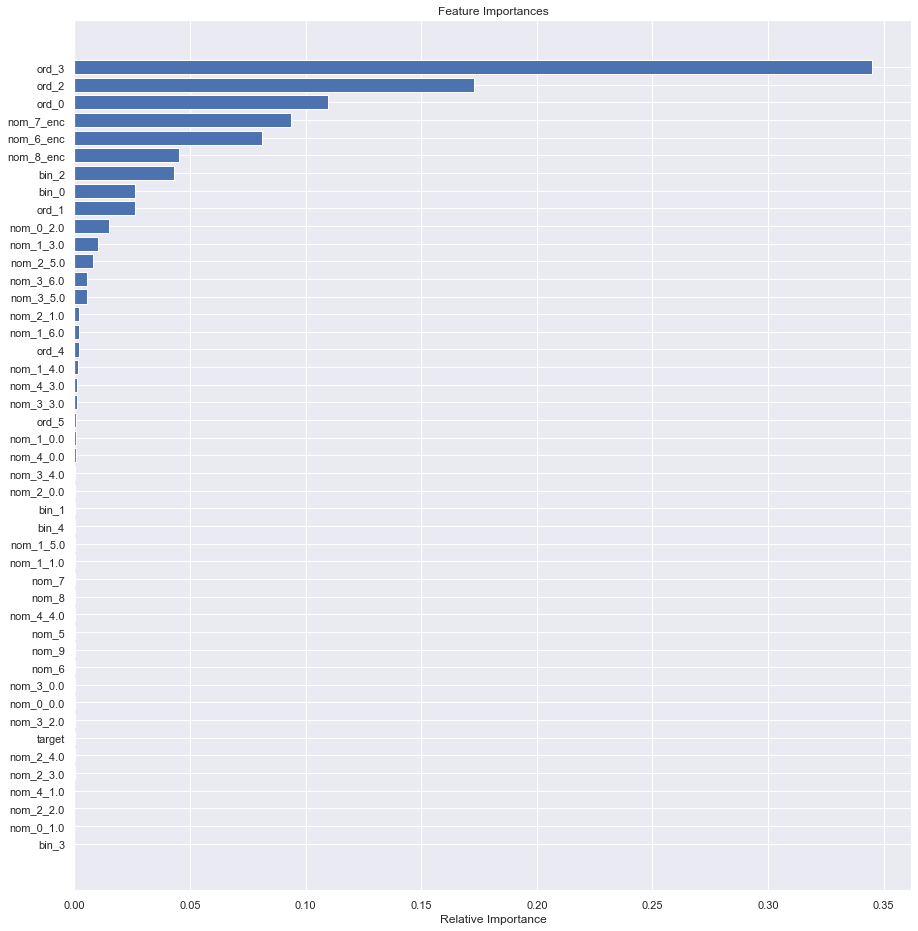

In [81]:
print(metrics.roc_auc_score(y_test, preds))
features = train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

fig, axs = plt.subplots(figsize = (15,16))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [65]:
test_preds = rf.predict_proba(test)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   21.2s finished


In [66]:
sub['target'] = test_preds

In [67]:
sub.head()

,id,target
0,600000,0.184685
1,600001,0.173307
2,600002,0.159679
3,600003,0.202325
4,600004,0.267302


In [68]:
sub.to_csv('../output/submission.csv', index = False)